In [1]:
# Importing the required libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Dataset loading
file_path = "amazon_reviews.xlsx"
dataset = pd.read_excel(file_path)

if dataset['review'].dtype == 'object':
    dataset['review'] = dataset['review'].astype(str)

# Text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word, tag in pos_tags:
        if tag.startswith('NN'):  # Noun
            pos = 'n'
        elif tag.startswith('VB'):  # Verb
            pos = 'v'
        else:
            pos = 'a'  # Adjective or adverb
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    no_punctuation_tokens = [token.translate(table) for token in lemmatized_tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in no_punctuation_tokens if word.lower() not in stop_words]
    
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

# Sentiment analysis implementation
def perform_sentiment_analysis(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        sentiment_label = "Positive"
    elif polarity == 0:
        sentiment_label = "Neutral"
    else:
        sentiment_label = "Negative"
    return sentiment_label, polarity


# Integration of text preprocessing and sentiment analysis results into the dataset
dataset['Preprocessed_review'] = dataset['review'].apply(preprocess_text)
dataset['Sentiment_Label'], dataset['Sentiment_Polarity'] = zip(*dataset['Preprocessed_review'].apply(perform_sentiment_analysis))

# Regression analysis
X = dataset['Sentiment_Polarity'].values.reshape(-1, 1)
y = dataset['Rating'].values.reshape(-1, 1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Making predictions
y_pred = regression_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yash\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Mean Squared Error: 0.95625974977299


In [2]:
# Displaying the updated dataset with sentiment analysis results
print(dataset.head(50))

    Unnamed: 0                                      reviewerName  Rating  \
0            0                                               NaN       4   
1            1                                              0mie       5   
2            2                                               1K3       4   
3            3                                               1m2       5   
4            4                                      2&amp;1/2Men       5   
5            5                                           2Cents!       5   
6            6                                        2K1Toaster       5   
7            7  35-year Technology Consumer "8-tracks to 802.11"       5   
8            8                                         4evryoung       5   
9            9                                          53rdcard       5   
10          10                                         808TREX50       5   
11          11                                             98020       3   
12          

In [3]:
#Hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],  # Whether to fit the intercept
}

# Create the GridSearchCV object
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Best Model):", mse)


Best Hyperparameters: {'fit_intercept': True}
Mean Squared Error (Best Model): 0.95625974977299


In [4]:
# Training multiple versions to check for best configuration
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of hyperparameters to explore
hyperparameters = [
    {'fit_intercept': True},
    {'fit_intercept': False}
]

# Train models with different hyperparameters
models = []
for params in hyperparameters:
    model = make_pipeline(StandardScaler(), LinearRegression(**params))
    model.fit(X_train, y_train)
    models.append(model)

# Evaluate model performance
mse_values = []
for model in models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Compare performance
best_model_index = mse_values.index(min(mse_values))
best_model = models[best_model_index]
best_params = hyperparameters[best_model_index]
best_mse = mse_values[best_model_index]

# Print results
print("Model Performances:")
for i, params in enumerate(hyperparameters):
    print(f"Model {i+1} Hyperparameters:", params)
    print(f"Model {i+1} MSE:", mse_values[i])
    print()

print("Best Model Hyperparameters:", best_params)
print("Best Model MSE:", best_mse)


Model Performances:
Model 1 Hyperparameters: {'fit_intercept': True}
Model 1 MSE: 0.95625974977299

Model 2 Hyperparameters: {'fit_intercept': False}
Model 2 MSE: 22.048699393634262

Best Model Hyperparameters: {'fit_intercept': True}
Best Model MSE: 0.95625974977299


In [5]:
# Adding n-Grams
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['Rating'], test_size=0.2, random_state=42)

# Define a pipeline for text feature extraction and modeling
text_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),  # Include both unigrams and bigrams
    ('regressor', LinearRegression())
])

# Train the model
text_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = text_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.6606734259013438


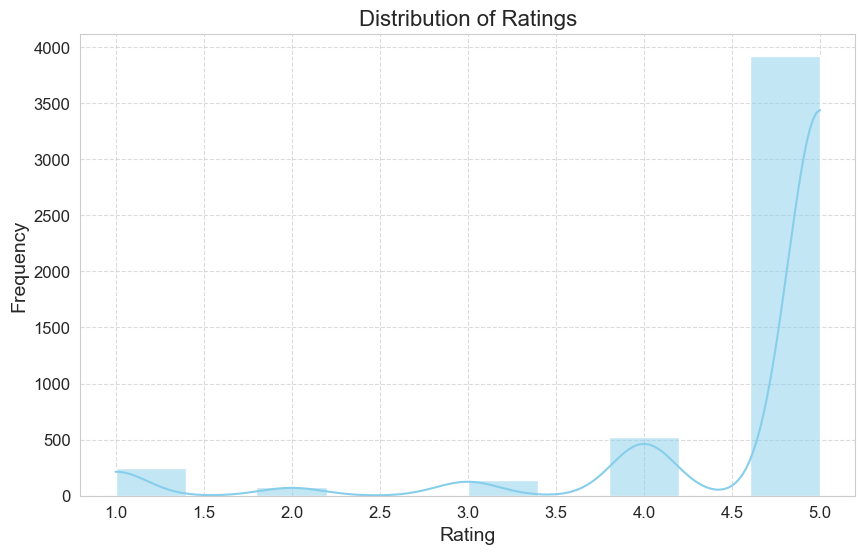

In [6]:
# Histogram of Ratings
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


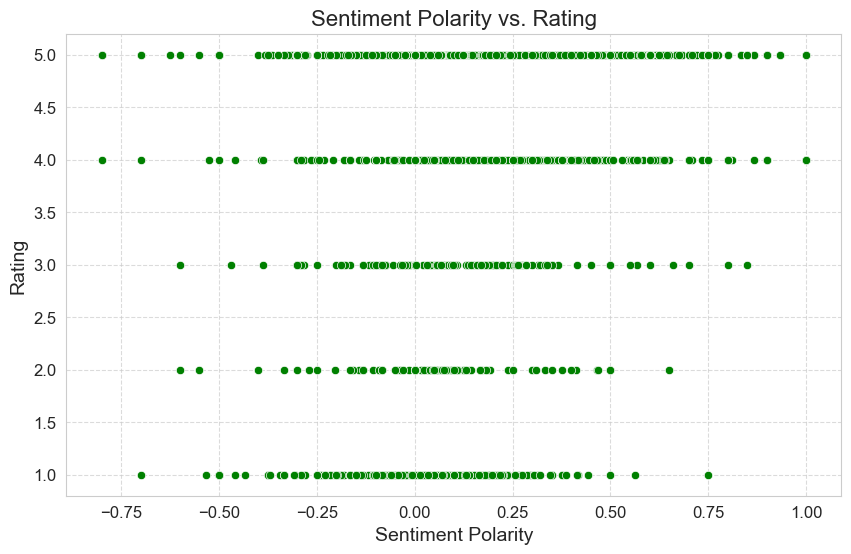

In [7]:
# Scatter Plot of Sentiment Polarity vs. Rating
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sentiment_Polarity', y='Rating', data=dataset, color='green')
plt.title('Sentiment Polarity vs. Rating', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


C:\Users\Yash\AppData\Local\Temp\ipykernel_44720\3206037885.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment_Label', y='Rating', data=dataset, palette='Set2')


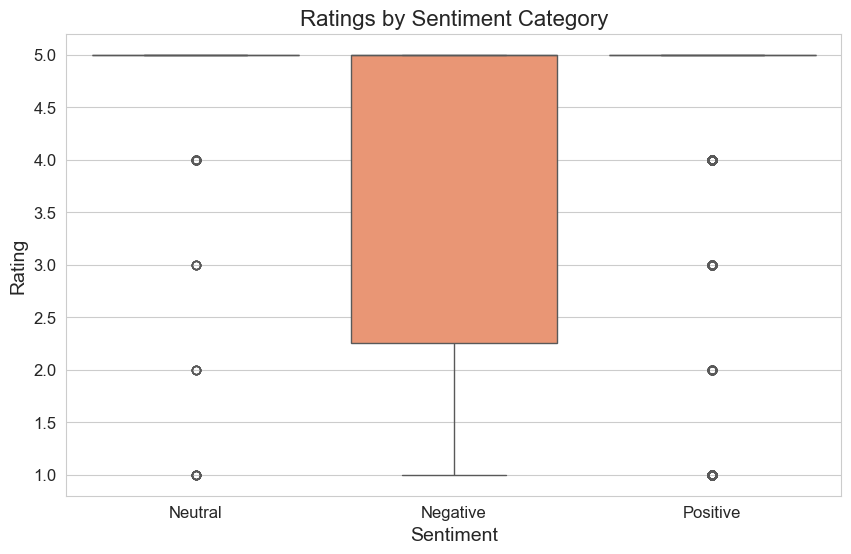

In [8]:
# Box Plot of Ratings by Sentiment Category
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment_Label', y='Rating', data=dataset, palette='Set2')
plt.title('Ratings by Sentiment Category', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


C:\Users\Yash\AppData\Local\Temp\ipykernel_44720\3059979241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment_Label', y='Rating', data=average_ratings, palette='pastel')


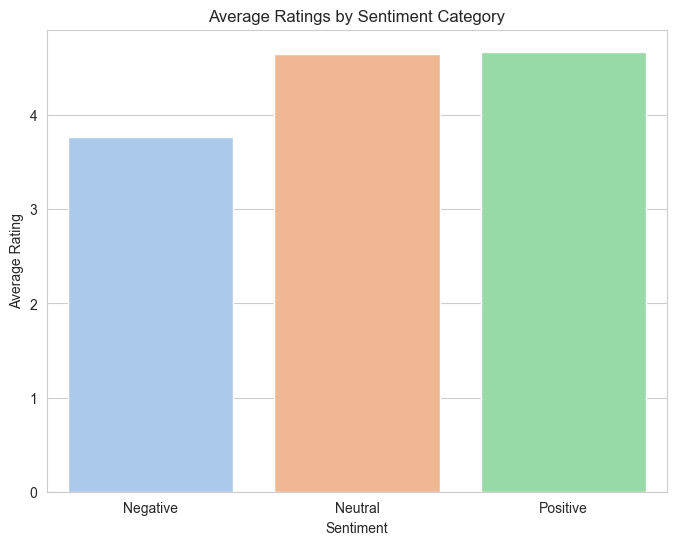

In [9]:
# Bar Plot of Average Ratings by Sentiment Category
average_ratings = dataset.groupby('Sentiment_Label')['Rating'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment_Label', y='Rating', data=average_ratings, palette='pastel')
plt.title('Average Ratings by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Average Rating')
plt.show()

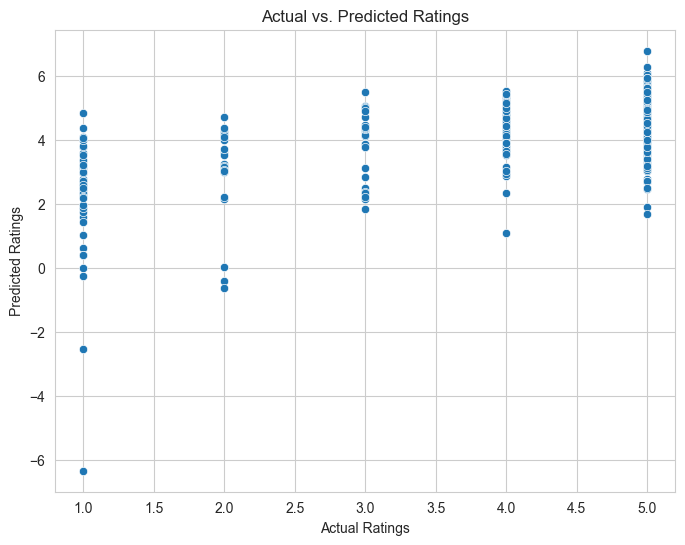

In [10]:
# ... (rest of your code)

# Visualizing Regression Analysis Results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.tolist(), y=y_pred.tolist())
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()
